<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:13:06] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


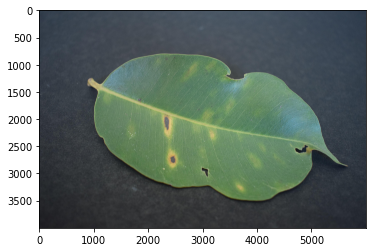

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

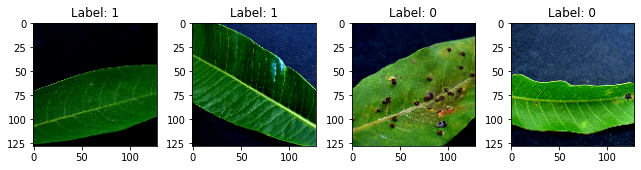

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:13:13] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:13:15] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2639742811629648 samples/sec                   batch loss = 0.3277866840362549 | accuracy = 0.75


Epoch[1] Batch[10] Speed: 1.2719268279628342 samples/sec                   batch loss = 0.5966539978981018 | accuracy = 0.725


Epoch[1] Batch[15] Speed: 1.2554812759692213 samples/sec                   batch loss = 0.2911466956138611 | accuracy = 0.6833333333333333


Epoch[1] Batch[20] Speed: 1.2591177163469531 samples/sec                   batch loss = 0.4436616003513336 | accuracy = 0.6875


Epoch[1] Batch[25] Speed: 1.2492096953566958 samples/sec                   batch loss = 0.7809098958969116 | accuracy = 0.65


Epoch[1] Batch[30] Speed: 1.2650254046132832 samples/sec                   batch loss = 0.6003755331039429 | accuracy = 0.65


Epoch[1] Batch[35] Speed: 1.274956184157021 samples/sec                   batch loss = 0.21525979042053223 | accuracy = 0.6571428571428571


Epoch[1] Batch[40] Speed: 1.26979269654192 samples/sec                   batch loss = 0.413083016872406 | accuracy = 0.6375


Epoch[1] Batch[45] Speed: 1.2687330634219218 samples/sec                   batch loss = 0.5945857763290405 | accuracy = 0.6333333333333333


Epoch[1] Batch[50] Speed: 1.2639836134021372 samples/sec                   batch loss = 0.34219542145729065 | accuracy = 0.65


Epoch[1] Batch[55] Speed: 1.2718761087172086 samples/sec                   batch loss = 1.1170610189437866 | accuracy = 0.6409090909090909


Epoch[1] Batch[60] Speed: 1.2716166938679638 samples/sec                   batch loss = 0.4774339199066162 | accuracy = 0.6375


Epoch[1] Batch[65] Speed: 1.270539197867442 samples/sec                   batch loss = 0.4595721960067749 | accuracy = 0.6384615384615384


Epoch[1] Batch[70] Speed: 1.265659362544992 samples/sec                   batch loss = 0.5924031138420105 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2730230041104675 samples/sec                   batch loss = 0.42768964171409607 | accuracy = 0.6466666666666666


Epoch[1] Batch[80] Speed: 1.2778907860362922 samples/sec                   batch loss = 0.29885706305503845 | accuracy = 0.659375


Epoch[1] Batch[85] Speed: 1.268821818402376 samples/sec                   batch loss = 0.47840607166290283 | accuracy = 0.6647058823529411


Epoch[1] Batch[90] Speed: 1.270597219959684 samples/sec                   batch loss = 0.3074937164783478 | accuracy = 0.6694444444444444


Epoch[1] Batch[95] Speed: 1.2657246744405217 samples/sec                   batch loss = 0.2051963210105896 | accuracy = 0.6710526315789473


Epoch[1] Batch[100] Speed: 1.2681715562994176 samples/sec                   batch loss = 1.1203835010528564 | accuracy = 0.6625


Epoch[1] Batch[105] Speed: 1.268482697383861 samples/sec                   batch loss = 0.43226948380470276 | accuracy = 0.6619047619047619


Epoch[1] Batch[110] Speed: 1.260442428603959 samples/sec                   batch loss = 0.5886293053627014 | accuracy = 0.6590909090909091


Epoch[1] Batch[115] Speed: 1.261558636869492 samples/sec                   batch loss = 0.35704439878463745 | accuracy = 0.6717391304347826


Epoch[1] Batch[120] Speed: 1.2581681826059457 samples/sec                   batch loss = 0.7940355539321899 | accuracy = 0.6708333333333333


Epoch[1] Batch[125] Speed: 1.263878871685666 samples/sec                   batch loss = 0.6404508948326111 | accuracy = 0.674


Epoch[1] Batch[130] Speed: 1.2717867331238757 samples/sec                   batch loss = 0.8156065940856934 | accuracy = 0.6711538461538461


Epoch[1] Batch[135] Speed: 1.2670068769562381 samples/sec                   batch loss = 1.004986047744751 | accuracy = 0.6685185185185185


Epoch[1] Batch[140] Speed: 1.2673100755179272 samples/sec                   batch loss = 0.6518509387969971 | accuracy = 0.6696428571428571


Epoch[1] Batch[145] Speed: 1.2576404025326995 samples/sec                   batch loss = 0.32304254174232483 | accuracy = 0.6689655172413793


Epoch[1] Batch[150] Speed: 1.2698551678322436 samples/sec                   batch loss = 0.38559919595718384 | accuracy = 0.6666666666666666


Epoch[1] Batch[155] Speed: 1.2674859550508744 samples/sec                   batch loss = 0.24396267533302307 | accuracy = 0.6661290322580645


Epoch[1] Batch[160] Speed: 1.2689492634826487 samples/sec                   batch loss = 0.5564641952514648 | accuracy = 0.665625


Epoch[1] Batch[165] Speed: 1.264517494465122 samples/sec                   batch loss = 1.647213339805603 | accuracy = 0.6575757575757576


Epoch[1] Batch[170] Speed: 1.2671597022873913 samples/sec                   batch loss = 0.6867246031761169 | accuracy = 0.6588235294117647


Epoch[1] Batch[175] Speed: 1.2715226327281028 samples/sec                   batch loss = 0.4230281710624695 | accuracy = 0.66


Epoch[1] Batch[180] Speed: 1.2733761551183984 samples/sec                   batch loss = 0.46886104345321655 | accuracy = 0.6555555555555556


Epoch[1] Batch[185] Speed: 1.2721148908847777 samples/sec                   batch loss = 0.7565562725067139 | accuracy = 0.6554054054054054


Epoch[1] Batch[190] Speed: 1.2742485186301666 samples/sec                   batch loss = 0.4739309847354889 | accuracy = 0.6578947368421053


Epoch[1] Batch[195] Speed: 1.263060484814146 samples/sec                   batch loss = 1.0300109386444092 | accuracy = 0.6576923076923077


Epoch[1] Batch[200] Speed: 1.2688015715784846 samples/sec                   batch loss = 0.39311736822128296 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.271923549410224 samples/sec                   batch loss = 0.2798302173614502 | accuracy = 0.6536585365853659


Epoch[1] Batch[210] Speed: 1.266717117252613 samples/sec                   batch loss = 0.4152085483074188 | accuracy = 0.6547619047619048


Epoch[1] Batch[215] Speed: 1.2764675878641503 samples/sec                   batch loss = 0.5557354092597961 | accuracy = 0.6569767441860465


Epoch[1] Batch[220] Speed: 1.2608025611013938 samples/sec                   batch loss = 0.6055096983909607 | accuracy = 0.6568181818181819


Epoch[1] Batch[225] Speed: 1.267231390738521 samples/sec                   batch loss = 0.5607929229736328 | accuracy = 0.6577777777777778


Epoch[1] Batch[230] Speed: 1.2790922457832126 samples/sec                   batch loss = 0.7117630243301392 | accuracy = 0.6597826086956522


Epoch[1] Batch[235] Speed: 1.2758008328453232 samples/sec                   batch loss = 0.20844611525535583 | accuracy = 0.6617021276595745


Epoch[1] Batch[240] Speed: 1.2664335126436779 samples/sec                   batch loss = 0.47841474413871765 | accuracy = 0.6635416666666667


Epoch[1] Batch[245] Speed: 1.2680811670338514 samples/sec                   batch loss = 0.8075029253959656 | accuracy = 0.6632653061224489


Epoch[1] Batch[250] Speed: 1.274874318934691 samples/sec                   batch loss = 0.4640709161758423 | accuracy = 0.663


Epoch[1] Batch[255] Speed: 1.2744778331679327 samples/sec                   batch loss = 0.9761202335357666 | accuracy = 0.6627450980392157


Epoch[1] Batch[260] Speed: 1.2746126145290444 samples/sec                   batch loss = 0.6011976599693298 | accuracy = 0.6615384615384615


Epoch[1] Batch[265] Speed: 1.2711782140573815 samples/sec                   batch loss = 0.5017333626747131 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.2667525050261348 samples/sec                   batch loss = 0.9407638907432556 | accuracy = 0.6620370370370371


Epoch[1] Batch[275] Speed: 1.264950055209379 samples/sec                   batch loss = 0.861577033996582 | accuracy = 0.6645454545454546


Epoch[1] Batch[280] Speed: 1.2697373425043057 samples/sec                   batch loss = 0.6563043594360352 | accuracy = 0.6616071428571428


Epoch[1] Batch[285] Speed: 1.2683741402277404 samples/sec                   batch loss = 0.5367643237113953 | accuracy = 0.6640350877192982


Epoch[1] Batch[290] Speed: 1.2733602083739073 samples/sec                   batch loss = 0.8134160041809082 | accuracy = 0.6620689655172414


Epoch[1] Batch[295] Speed: 1.2671731970903655 samples/sec                   batch loss = 0.3714444041252136 | accuracy = 0.6635593220338983


Epoch[1] Batch[300] Speed: 1.2652191605574645 samples/sec                   batch loss = 0.4953799843788147 | accuracy = 0.6658333333333334


Epoch[1] Batch[305] Speed: 1.2751693737096554 samples/sec                   batch loss = 0.6899625062942505 | accuracy = 0.6672131147540984


Epoch[1] Batch[310] Speed: 1.2710343360463334 samples/sec                   batch loss = 0.41032636165618896 | accuracy = 0.6709677419354839


Epoch[1] Batch[315] Speed: 1.2725352919773663 samples/sec                   batch loss = 0.7106144428253174 | accuracy = 0.669047619047619


Epoch[1] Batch[320] Speed: 1.269594174758898 samples/sec                   batch loss = 0.5641303062438965 | accuracy = 0.66796875


Epoch[1] Batch[325] Speed: 1.2625684029787712 samples/sec                   batch loss = 0.6041116118431091 | accuracy = 0.6684615384615384


Epoch[1] Batch[330] Speed: 1.2681150974426234 samples/sec                   batch loss = 0.5338746309280396 | accuracy = 0.6704545454545454


Epoch[1] Batch[335] Speed: 1.2684304303558098 samples/sec                   batch loss = 0.505668044090271 | accuracy = 0.6694029850746268


Epoch[1] Batch[340] Speed: 1.277701692748266 samples/sec                   batch loss = 0.5028802752494812 | accuracy = 0.6698529411764705


Epoch[1] Batch[345] Speed: 1.2682357855594124 samples/sec                   batch loss = 0.9300135970115662 | accuracy = 0.6702898550724637


Epoch[1] Batch[350] Speed: 1.268905595304724 samples/sec                   batch loss = 1.5176150798797607 | accuracy = 0.6714285714285714


Epoch[1] Batch[355] Speed: 1.2718914397736416 samples/sec                   batch loss = 0.45668861269950867 | accuracy = 0.6725352112676056


Epoch[1] Batch[360] Speed: 1.2783738458913767 samples/sec                   batch loss = 0.33747997879981995 | accuracy = 0.675


Epoch[1] Batch[365] Speed: 1.2771394150583433 samples/sec                   batch loss = 0.6468797922134399 | accuracy = 0.6767123287671233


Epoch[1] Batch[370] Speed: 1.2714312833848722 samples/sec                   batch loss = 1.0853086709976196 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2631472115614466 samples/sec                   batch loss = 0.4490870237350464 | accuracy = 0.6773333333333333


Epoch[1] Batch[380] Speed: 1.268348058591377 samples/sec                   batch loss = 0.215705007314682 | accuracy = 0.680921052631579


Epoch[1] Batch[385] Speed: 1.2751309943286777 samples/sec                   batch loss = 0.3938863277435303 | accuracy = 0.6831168831168831


Epoch[1] Batch[390] Speed: 1.2740757886493663 samples/sec                   batch loss = 0.2542198896408081 | accuracy = 0.6833333333333333


Epoch[1] Batch[395] Speed: 1.267529717096026 samples/sec                   batch loss = 0.31099948287010193 | accuracy = 0.6841772151898734


Epoch[1] Batch[400] Speed: 1.2711004927733371 samples/sec                   batch loss = 1.4488258361816406 | accuracy = 0.681875


Epoch[1] Batch[405] Speed: 1.2706628500062294 samples/sec                   batch loss = 0.5316687822341919 | accuracy = 0.6802469135802469


Epoch[1] Batch[410] Speed: 1.271437160953824 samples/sec                   batch loss = 0.5491625070571899 | accuracy = 0.6804878048780488


Epoch[1] Batch[415] Speed: 1.2696232861214412 samples/sec                   batch loss = 0.4698559641838074 | accuracy = 0.6801204819277108


Epoch[1] Batch[420] Speed: 1.2776982870518594 samples/sec                   batch loss = 1.347497582435608 | accuracy = 0.680952380952381


Epoch[1] Batch[425] Speed: 1.270273980267509 samples/sec                   batch loss = 0.5501440763473511 | accuracy = 0.6823529411764706


Epoch[1] Batch[430] Speed: 1.2629927853679912 samples/sec                   batch loss = 1.2624900341033936 | accuracy = 0.6813953488372093


Epoch[1] Batch[435] Speed: 1.2733005807532891 samples/sec                   batch loss = 0.7705051898956299 | accuracy = 0.6810344827586207


Epoch[1] Batch[440] Speed: 1.2745705891210188 samples/sec                   batch loss = 0.7291194200515747 | accuracy = 0.6823863636363636


Epoch[1] Batch[445] Speed: 1.2745170446322875 samples/sec                   batch loss = 0.34607410430908203 | accuracy = 0.6831460674157304


Epoch[1] Batch[450] Speed: 1.26325753910781 samples/sec                   batch loss = 0.41913026571273804 | accuracy = 0.685


Epoch[1] Batch[455] Speed: 1.2559195215754568 samples/sec                   batch loss = 0.32532787322998047 | accuracy = 0.6857142857142857


Epoch[1] Batch[460] Speed: 1.2674343446186445 samples/sec                   batch loss = 0.45358991622924805 | accuracy = 0.6858695652173913


Epoch[1] Batch[465] Speed: 1.2734952367701322 samples/sec                   batch loss = 0.6850240230560303 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.2718417839184017 samples/sec                   batch loss = 0.8822107315063477 | accuracy = 0.6835106382978723


Epoch[1] Batch[475] Speed: 1.2685417786969384 samples/sec                   batch loss = 0.37522852420806885 | accuracy = 0.6831578947368421


Epoch[1] Batch[480] Speed: 1.260194850340925 samples/sec                   batch loss = 0.6930679678916931 | accuracy = 0.6828125


Epoch[1] Batch[485] Speed: 1.27110424860197 samples/sec                   batch loss = 0.7996900081634521 | accuracy = 0.681958762886598


Epoch[1] Batch[490] Speed: 1.268241058399568 samples/sec                   batch loss = 0.3372766971588135 | accuracy = 0.6826530612244898


Epoch[1] Batch[495] Speed: 1.271726481587378 samples/sec                   batch loss = 0.44362762570381165 | accuracy = 0.6833333333333333


Epoch[1] Batch[500] Speed: 1.2687038969284559 samples/sec                   batch loss = 0.49273085594177246 | accuracy = 0.683


Epoch[1] Batch[505] Speed: 1.2598817061629026 samples/sec                   batch loss = 0.36467042565345764 | accuracy = 0.6831683168316832


Epoch[1] Batch[510] Speed: 1.2712408217548883 samples/sec                   batch loss = 0.5883185863494873 | accuracy = 0.682843137254902


Epoch[1] Batch[515] Speed: 1.269723216465609 samples/sec                   batch loss = 0.4777655303478241 | accuracy = 0.683009708737864


Epoch[1] Batch[520] Speed: 1.2683413465790907 samples/sec                   batch loss = 0.46951863169670105 | accuracy = 0.6831730769230769


Epoch[1] Batch[525] Speed: 1.2669843916812524 samples/sec                   batch loss = 0.603940486907959 | accuracy = 0.6823809523809524


Epoch[1] Batch[530] Speed: 1.2609991957729223 samples/sec                   batch loss = 0.7695720195770264 | accuracy = 0.6820754716981132


Epoch[1] Batch[535] Speed: 1.2668811610242086 samples/sec                   batch loss = 0.3905830979347229 | accuracy = 0.6817757009345794


Epoch[1] Batch[540] Speed: 1.2708792269711688 samples/sec                   batch loss = 0.6791912913322449 | accuracy = 0.6814814814814815


Epoch[1] Batch[545] Speed: 1.2719743688750962 samples/sec                   batch loss = 0.7168548107147217 | accuracy = 0.6825688073394496


Epoch[1] Batch[550] Speed: 1.2707801733880228 samples/sec                   batch loss = 0.5285539031028748 | accuracy = 0.6827272727272727


Epoch[1] Batch[555] Speed: 1.264446017434464 samples/sec                   batch loss = 0.3422926068305969 | accuracy = 0.6842342342342342


Epoch[1] Batch[560] Speed: 1.2689008927571326 samples/sec                   batch loss = 0.7175931930541992 | accuracy = 0.684375


Epoch[1] Batch[565] Speed: 1.2681978224045498 samples/sec                   batch loss = 0.38910025358200073 | accuracy = 0.684070796460177


Epoch[1] Batch[570] Speed: 1.2671614250121923 samples/sec                   batch loss = 0.8753317594528198 | accuracy = 0.6837719298245614


Epoch[1] Batch[575] Speed: 1.2754338277916624 samples/sec                   batch loss = 1.6456220149993896 | accuracy = 0.6839130434782609


Epoch[1] Batch[580] Speed: 1.2609780605269192 samples/sec                   batch loss = 0.3867383599281311 | accuracy = 0.6849137931034482


Epoch[1] Batch[585] Speed: 1.2711432527498339 samples/sec                   batch loss = 0.6400274634361267 | accuracy = 0.6854700854700855


Epoch[1] Batch[590] Speed: 1.268177116187097 samples/sec                   batch loss = 0.6822545528411865 | accuracy = 0.6860169491525424


Epoch[1] Batch[595] Speed: 1.2692483032902286 samples/sec                   batch loss = 0.33500543236732483 | accuracy = 0.6865546218487395


Epoch[1] Batch[600] Speed: 1.2713541092012206 samples/sec                   batch loss = 0.7086925506591797 | accuracy = 0.6858333333333333


Epoch[1] Batch[605] Speed: 1.265912149378276 samples/sec                   batch loss = 0.3334094285964966 | accuracy = 0.6871900826446281


Epoch[1] Batch[610] Speed: 1.2614506924769122 samples/sec                   batch loss = 1.025701642036438 | accuracy = 0.6889344262295082


Epoch[1] Batch[615] Speed: 1.274501747033234 samples/sec                   batch loss = 0.9446730613708496 | accuracy = 0.6890243902439024


Epoch[1] Batch[620] Speed: 1.2678515614845303 samples/sec                   batch loss = 0.38334983587265015 | accuracy = 0.6895161290322581


Epoch[1] Batch[625] Speed: 1.2713234733592318 samples/sec                   batch loss = 0.8225923776626587 | accuracy = 0.6904


Epoch[1] Batch[630] Speed: 1.2632564928078058 samples/sec                   batch loss = 0.7949792742729187 | accuracy = 0.6900793650793651


Epoch[1] Batch[635] Speed: 1.2666843135961035 samples/sec                   batch loss = 0.33934611082077026 | accuracy = 0.6917322834645669


Epoch[1] Batch[640] Speed: 1.2695983059930898 samples/sec                   batch loss = 1.2765202522277832 | accuracy = 0.692578125


Epoch[1] Batch[645] Speed: 1.2770825437463837 samples/sec                   batch loss = 0.7235762476921082 | accuracy = 0.6926356589147287


Epoch[1] Batch[650] Speed: 1.2746826307524375 samples/sec                   batch loss = 0.6142959594726562 | accuracy = 0.6926923076923077


Epoch[1] Batch[655] Speed: 1.2649875380313227 samples/sec                   batch loss = 0.42196112871170044 | accuracy = 0.6935114503816794


Epoch[1] Batch[660] Speed: 1.2629264241350209 samples/sec                   batch loss = 0.3769688010215759 | accuracy = 0.6946969696969697


Epoch[1] Batch[665] Speed: 1.2678789641206285 samples/sec                   batch loss = 0.5886970162391663 | accuracy = 0.6943609022556391


Epoch[1] Batch[670] Speed: 1.2742791988238835 samples/sec                   batch loss = 0.5805707573890686 | accuracy = 0.6947761194029851


Epoch[1] Batch[675] Speed: 1.2754489538480742 samples/sec                   batch loss = 0.2899468243122101 | accuracy = 0.6940740740740741


Epoch[1] Batch[680] Speed: 1.2625018013201277 samples/sec                   batch loss = 0.6660343408584595 | accuracy = 0.6948529411764706


Epoch[1] Batch[685] Speed: 1.2646642859695003 samples/sec                   batch loss = 0.10324129462242126 | accuracy = 0.6956204379562044


Epoch[1] Batch[690] Speed: 1.274040667777954 samples/sec                   batch loss = 0.3147051930427551 | accuracy = 0.6960144927536231


Epoch[1] Batch[695] Speed: 1.2725238061359174 samples/sec                   batch loss = 0.5500159859657288 | accuracy = 0.6949640287769784


Epoch[1] Batch[700] Speed: 1.2702069478675986 samples/sec                   batch loss = 0.6605929136276245 | accuracy = 0.6939285714285715


Epoch[1] Batch[705] Speed: 1.2683917842958834 samples/sec                   batch loss = 0.4409230053424835 | accuracy = 0.6936170212765957


Epoch[1] Batch[710] Speed: 1.2670341474031799 samples/sec                   batch loss = 0.6656540036201477 | accuracy = 0.6943661971830986


Epoch[1] Batch[715] Speed: 1.272604018318526 samples/sec                   batch loss = 0.07762811332941055 | accuracy = 0.6944055944055944


Epoch[1] Batch[720] Speed: 1.2727535623668527 samples/sec                   batch loss = 0.5059913992881775 | accuracy = 0.6951388888888889


Epoch[1] Batch[725] Speed: 1.26730615061978 samples/sec                   batch loss = 0.36897364258766174 | accuracy = 0.6958620689655173


Epoch[1] Batch[730] Speed: 1.268477614346186 samples/sec                   batch loss = 0.3893621563911438 | accuracy = 0.696917808219178


Epoch[1] Batch[735] Speed: 1.264129804725842 samples/sec                   batch loss = 0.3341107964515686 | accuracy = 0.6976190476190476


Epoch[1] Batch[740] Speed: 1.2703725701796655 samples/sec                   batch loss = 1.0927081108093262 | accuracy = 0.6966216216216217


Epoch[1] Batch[745] Speed: 1.2753424003585538 samples/sec                   batch loss = 0.44141149520874023 | accuracy = 0.697986577181208


Epoch[1] Batch[750] Speed: 1.2683592773990842 samples/sec                   batch loss = 1.1280497312545776 | accuracy = 0.698


Epoch[1] Batch[755] Speed: 1.2704072967100002 samples/sec                   batch loss = 0.23226284980773926 | accuracy = 0.6980132450331126


Epoch[1] Batch[760] Speed: 1.2586003751821635 samples/sec                   batch loss = 0.8098592758178711 | accuracy = 0.6976973684210527


Epoch[1] Batch[765] Speed: 1.2715290893492146 samples/sec                   batch loss = 0.545745313167572 | accuracy = 0.6973856209150326


Epoch[1] Batch[770] Speed: 1.272157815601897 samples/sec                   batch loss = 0.6622814536094666 | accuracy = 0.6977272727272728


Epoch[1] Batch[775] Speed: 1.26942923558448 samples/sec                   batch loss = 0.882077157497406 | accuracy = 0.6980645161290323


Epoch[1] Batch[780] Speed: 1.2667815818656778 samples/sec                   batch loss = 0.40988948941230774 | accuracy = 0.6987179487179487


Epoch[1] Batch[785] Speed: 1.2638662086362602 samples/sec                   batch loss = 0.6073872447013855 | accuracy = 0.6990445859872612


[Epoch 1] training: accuracy=0.6995558375634517
[Epoch 1] time cost: 648.0121922492981
[Epoch 1] validation: validation accuracy=0.7133333333333334


Epoch[2] Batch[5] Speed: 1.2757030476493323 samples/sec                   batch loss = 0.272580623626709 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.27721408457352 samples/sec                   batch loss = 0.5337913632392883 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2710419432380295 samples/sec                   batch loss = 0.28945085406303406 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2759292957032453 samples/sec                   batch loss = 0.8460736870765686 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.2714621171386749 samples/sec                   batch loss = 0.5640528202056885 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.2713778096390673 samples/sec                   batch loss = 0.5814307332038879 | accuracy = 0.8


Epoch[2] Batch[35] Speed: 1.2736346447241254 samples/sec                   batch loss = 0.6668117046356201 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.2712311894000217 samples/sec                   batch loss = 0.33214834332466125 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2708062588883144 samples/sec                   batch loss = 0.31087690591812134 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.274143230021244 samples/sec                   batch loss = 0.8215795755386353 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2759865495697698 samples/sec                   batch loss = 0.24435389041900635 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2733663937304154 samples/sec                   batch loss = 0.36219361424446106 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2720811319063745 samples/sec                   batch loss = 0.22143682837486267 | accuracy = 0.7769230769230769


Epoch[2] Batch[70] Speed: 1.2673313278276603 samples/sec                   batch loss = 0.9364389777183533 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2782675822958447 samples/sec                   batch loss = 0.6175663471221924 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.2707420577561 samples/sec                   batch loss = 0.6820193529129028 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.277638155174265 samples/sec                   batch loss = 0.27797240018844604 | accuracy = 0.7588235294117647


Epoch[2] Batch[90] Speed: 1.2670828543851513 samples/sec                   batch loss = 0.14406508207321167 | accuracy = 0.7611111111111111


Epoch[2] Batch[95] Speed: 1.2699837819322777 samples/sec                   batch loss = 0.4913872480392456 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.2766567046062005 samples/sec                   batch loss = 0.17937451601028442 | accuracy = 0.7675


Epoch[2] Batch[105] Speed: 1.2831723939075144 samples/sec                   batch loss = 0.49976587295532227 | accuracy = 0.7714285714285715


Epoch[2] Batch[110] Speed: 1.276175426716853 samples/sec                   batch loss = 0.23108120262622833 | accuracy = 0.7704545454545455


Epoch[2] Batch[115] Speed: 1.2688000363006602 samples/sec                   batch loss = 0.7410223484039307 | accuracy = 0.7739130434782608


Epoch[2] Batch[120] Speed: 1.2689150005044736 samples/sec                   batch loss = 0.22131915390491486 | accuracy = 0.7791666666666667


Epoch[2] Batch[125] Speed: 1.2851246344964007 samples/sec                   batch loss = 0.5800083875656128 | accuracy = 0.78


Epoch[2] Batch[130] Speed: 1.267556818520945 samples/sec                   batch loss = 0.5894381403923035 | accuracy = 0.7807692307692308


Epoch[2] Batch[135] Speed: 1.2730393287981432 samples/sec                   batch loss = 0.35599517822265625 | accuracy = 0.7796296296296297


Epoch[2] Batch[140] Speed: 1.2723701667506206 samples/sec                   batch loss = 0.26897212862968445 | accuracy = 0.7803571428571429


Epoch[2] Batch[145] Speed: 1.2710846992753235 samples/sec                   batch loss = 0.6357152462005615 | accuracy = 0.7724137931034483


Epoch[2] Batch[150] Speed: 1.2751273115802673 samples/sec                   batch loss = 0.2363312691450119 | accuracy = 0.7766666666666666


Epoch[2] Batch[155] Speed: 1.2761076729844478 samples/sec                   batch loss = 0.44905537366867065 | accuracy = 0.7758064516129032


Epoch[2] Batch[160] Speed: 1.278766424356875 samples/sec                   batch loss = 0.6412316560745239 | accuracy = 0.76875


Epoch[2] Batch[165] Speed: 1.2792312237282328 samples/sec                   batch loss = 0.6120508909225464 | accuracy = 0.7712121212121212


Epoch[2] Batch[170] Speed: 1.274375797851371 samples/sec                   batch loss = 0.5081676840782166 | accuracy = 0.7691176470588236


Epoch[2] Batch[175] Speed: 1.2710287510774854 samples/sec                   batch loss = 0.5891721248626709 | accuracy = 0.7671428571428571


Epoch[2] Batch[180] Speed: 1.2798096962663252 samples/sec                   batch loss = 0.48482653498649597 | accuracy = 0.7625


Epoch[2] Batch[185] Speed: 1.2778507827373167 samples/sec                   batch loss = 0.5098544359207153 | accuracy = 0.7635135135135135


Epoch[2] Batch[190] Speed: 1.2756022708575812 samples/sec                   batch loss = 0.348141610622406 | accuracy = 0.7644736842105263


Epoch[2] Batch[195] Speed: 1.27106630612295 samples/sec                   batch loss = 0.6765397787094116 | accuracy = 0.7615384615384615


Epoch[2] Batch[200] Speed: 1.2743847035090285 samples/sec                   batch loss = 0.15445350110530853 | accuracy = 0.76125


Epoch[2] Batch[205] Speed: 1.2778945820998804 samples/sec                   batch loss = 0.3446139991283417 | accuracy = 0.7597560975609756


Epoch[2] Batch[210] Speed: 1.2769824236596672 samples/sec                   batch loss = 0.7937399744987488 | accuracy = 0.7607142857142857


Epoch[2] Batch[215] Speed: 1.2764741919216667 samples/sec                   batch loss = 0.2883889675140381 | accuracy = 0.7581395348837209


Epoch[2] Batch[220] Speed: 1.2636954250777306 samples/sec                   batch loss = 0.40707510709762573 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2634269674513414 samples/sec                   batch loss = 0.4410155415534973 | accuracy = 0.7622222222222222


Epoch[2] Batch[230] Speed: 1.2678319204636712 samples/sec                   batch loss = 0.3171771168708801 | accuracy = 0.7619565217391304


Epoch[2] Batch[235] Speed: 1.2674402810407064 samples/sec                   batch loss = 0.6509735584259033 | accuracy = 0.7574468085106383


Epoch[2] Batch[240] Speed: 1.2742884902781022 samples/sec                   batch loss = 0.09134937077760696 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.272214345603645 samples/sec                   batch loss = 0.2239016592502594 | accuracy = 0.7602040816326531


Epoch[2] Batch[250] Speed: 1.263759011332406 samples/sec                   batch loss = 0.5481652617454529 | accuracy = 0.762


Epoch[2] Batch[255] Speed: 1.2720406234973518 samples/sec                   batch loss = 0.4979286193847656 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.2737949725948177 samples/sec                   batch loss = 1.0087502002716064 | accuracy = 0.7586538461538461


Epoch[2] Batch[265] Speed: 1.274536215559686 samples/sec                   batch loss = 0.1825532615184784 | accuracy = 0.7575471698113208


Epoch[2] Batch[270] Speed: 1.2716651754840482 samples/sec                   batch loss = 0.4945748448371887 | accuracy = 0.7564814814814815


Epoch[2] Batch[275] Speed: 1.2672254562730894 samples/sec                   batch loss = 0.3565724194049835 | accuracy = 0.7554545454545455


Epoch[2] Batch[280] Speed: 1.278320468384853 samples/sec                   batch loss = 0.1201646700501442 | accuracy = 0.7598214285714285


Epoch[2] Batch[285] Speed: 1.2643887463389383 samples/sec                   batch loss = 0.5306048393249512 | accuracy = 0.7596491228070176


Epoch[2] Batch[290] Speed: 1.2701455958607277 samples/sec                   batch loss = 0.2619239091873169 | accuracy = 0.7612068965517241


Epoch[2] Batch[295] Speed: 1.268021649431786 samples/sec                   batch loss = 0.5110917091369629 | accuracy = 0.7610169491525424


Epoch[2] Batch[300] Speed: 1.2619191228342141 samples/sec                   batch loss = 0.21620720624923706 | accuracy = 0.7625


Epoch[2] Batch[305] Speed: 1.2687849715841049 samples/sec                   batch loss = 0.4409596025943756 | accuracy = 0.7639344262295082


Epoch[2] Batch[310] Speed: 1.2705117763346467 samples/sec                   batch loss = 0.3051964044570923 | accuracy = 0.7620967741935484


Epoch[2] Batch[315] Speed: 1.2692897863925594 samples/sec                   batch loss = 0.3537643849849701 | accuracy = 0.7603174603174603


Epoch[2] Batch[320] Speed: 1.271358829949667 samples/sec                   batch loss = 0.3834630846977234 | accuracy = 0.7609375


Epoch[2] Batch[325] Speed: 1.258563175502226 samples/sec                   batch loss = 0.19319388270378113 | accuracy = 0.7607692307692308


Epoch[2] Batch[330] Speed: 1.2681606283864015 samples/sec                   batch loss = 0.12301783263683319 | accuracy = 0.7621212121212121


Epoch[2] Batch[335] Speed: 1.2734105627883059 samples/sec                   batch loss = 0.5467736721038818 | accuracy = 0.7626865671641792


Epoch[2] Batch[340] Speed: 1.26958908280956 samples/sec                   batch loss = 0.2554253041744232 | accuracy = 0.7595588235294117


Epoch[2] Batch[345] Speed: 1.2747122664915913 samples/sec                   batch loss = 0.2620336711406708 | accuracy = 0.7615942028985507


Epoch[2] Batch[350] Speed: 1.2611676396232618 samples/sec                   batch loss = 0.6689943671226501 | accuracy = 0.7592857142857142


Epoch[2] Batch[355] Speed: 1.2683222656750541 samples/sec                   batch loss = 0.3291252553462982 | accuracy = 0.7577464788732394


Epoch[2] Batch[360] Speed: 1.2792252738781704 samples/sec                   batch loss = 0.9138973355293274 | accuracy = 0.7590277777777777


Epoch[2] Batch[365] Speed: 1.270455301328096 samples/sec                   batch loss = 0.45145025849342346 | accuracy = 0.7589041095890411


Epoch[2] Batch[370] Speed: 1.2722730996835927 samples/sec                   batch loss = 0.46200308203697205 | accuracy = 0.7601351351351351


Epoch[2] Batch[375] Speed: 1.2636728668215764 samples/sec                   batch loss = 0.5676367878913879 | accuracy = 0.7586666666666667


Epoch[2] Batch[380] Speed: 1.2665095169298821 samples/sec                   batch loss = 0.8298153281211853 | accuracy = 0.7585526315789474


Epoch[2] Batch[385] Speed: 1.2706734361325733 samples/sec                   batch loss = 0.5280389189720154 | accuracy = 0.7577922077922078


Epoch[2] Batch[390] Speed: 1.272327517169413 samples/sec                   batch loss = 0.5250383615493774 | accuracy = 0.7583333333333333


Epoch[2] Batch[395] Speed: 1.2699354284336222 samples/sec                   batch loss = 0.24273334443569183 | accuracy = 0.7601265822784811


Epoch[2] Batch[400] Speed: 1.262283423784403 samples/sec                   batch loss = 0.5833480358123779 | accuracy = 0.759375


Epoch[2] Batch[405] Speed: 1.265515108254572 samples/sec                   batch loss = 0.07726389169692993 | accuracy = 0.7580246913580246


Epoch[2] Batch[410] Speed: 1.2718561499711132 samples/sec                   batch loss = 0.610813558101654 | accuracy = 0.7579268292682927


Epoch[2] Batch[415] Speed: 1.2721288772721941 samples/sec                   batch loss = 0.16326943039894104 | accuracy = 0.7584337349397591


Epoch[2] Batch[420] Speed: 1.2711055968535598 samples/sec                   batch loss = 0.1986883580684662 | accuracy = 0.7595238095238095


Epoch[2] Batch[425] Speed: 1.2638938201231875 samples/sec                   batch loss = 0.14731989800930023 | accuracy = 0.76


Epoch[2] Batch[430] Speed: 1.2633508570148013 samples/sec                   batch loss = 0.6074193716049194 | accuracy = 0.7598837209302326


Epoch[2] Batch[435] Speed: 1.2731782504766294 samples/sec                   batch loss = 0.46938955783843994 | accuracy = 0.7609195402298851


Epoch[2] Batch[440] Speed: 1.2731361263755547 samples/sec                   batch loss = 0.0943109393119812 | accuracy = 0.7602272727272728


Epoch[2] Batch[445] Speed: 1.2751129684471176 samples/sec                   batch loss = 0.6517506241798401 | accuracy = 0.7589887640449439


Epoch[2] Batch[450] Speed: 1.2689736421903457 samples/sec                   batch loss = 0.5830410718917847 | accuracy = 0.7594444444444445


Epoch[2] Batch[455] Speed: 1.2707761307126055 samples/sec                   batch loss = 0.41331925988197327 | accuracy = 0.7598901098901099


Epoch[2] Batch[460] Speed: 1.2666276045765912 samples/sec                   batch loss = 0.37031838297843933 | accuracy = 0.7581521739130435


Epoch[2] Batch[465] Speed: 1.2711733983360776 samples/sec                   batch loss = 0.6945213675498962 | accuracy = 0.7580645161290323


Epoch[2] Batch[470] Speed: 1.2745805626421653 samples/sec                   batch loss = 0.6662262678146362 | accuracy = 0.7579787234042553


Epoch[2] Batch[475] Speed: 1.2732607676881131 samples/sec                   batch loss = 0.1349547952413559 | accuracy = 0.7573684210526316


Epoch[2] Batch[480] Speed: 1.2737407196234933 samples/sec                   batch loss = 0.5417199730873108 | accuracy = 0.7567708333333333


Epoch[2] Batch[485] Speed: 1.2726663803829996 samples/sec                   batch loss = 0.9303370714187622 | accuracy = 0.7546391752577319


Epoch[2] Batch[490] Speed: 1.2712519954694093 samples/sec                   batch loss = 0.3230900764465332 | accuracy = 0.7540816326530613


Epoch[2] Batch[495] Speed: 1.2774033253326291 samples/sec                   batch loss = 0.43787050247192383 | accuracy = 0.7540404040404041


Epoch[2] Batch[500] Speed: 1.2731230839277583 samples/sec                   batch loss = 0.5535772442817688 | accuracy = 0.7535


Epoch[2] Batch[505] Speed: 1.2672973436197343 samples/sec                   batch loss = 0.2629607617855072 | accuracy = 0.753960396039604


Epoch[2] Batch[510] Speed: 1.270697303682748 samples/sec                   batch loss = 0.4677470922470093 | accuracy = 0.7509803921568627


Epoch[2] Batch[515] Speed: 1.2714996014346835 samples/sec                   batch loss = 0.6253237724304199 | accuracy = 0.7509708737864078


Epoch[2] Batch[520] Speed: 1.2755631865510522 samples/sec                   batch loss = 1.0440185070037842 | accuracy = 0.7504807692307692


Epoch[2] Batch[525] Speed: 1.273942184863587 samples/sec                   batch loss = 0.16100503504276276 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.2706462975076582 samples/sec                   batch loss = 0.6559447050094604 | accuracy = 0.7514150943396226


Epoch[2] Batch[535] Speed: 1.267747039927737 samples/sec                   batch loss = 0.6939864158630371 | accuracy = 0.7504672897196262


Epoch[2] Batch[540] Speed: 1.27333092539236 samples/sec                   batch loss = 0.4172780513763428 | accuracy = 0.749537037037037


Epoch[2] Batch[545] Speed: 1.2748474849308615 samples/sec                   batch loss = 0.2852735221385956 | accuracy = 0.7490825688073395


Epoch[2] Batch[550] Speed: 1.2740294449876126 samples/sec                   batch loss = 0.3723765015602112 | accuracy = 0.7490909090909091


Epoch[2] Batch[555] Speed: 1.2665888770513387 samples/sec                   batch loss = 0.1342983990907669 | accuracy = 0.75


Epoch[2] Batch[560] Speed: 1.2719215244302904 samples/sec                   batch loss = 0.40845122933387756 | accuracy = 0.7504464285714286


Epoch[2] Batch[565] Speed: 1.2718235616741582 samples/sec                   batch loss = 0.6753285527229309 | accuracy = 0.7491150442477876


Epoch[2] Batch[570] Speed: 1.2778734606990991 samples/sec                   batch loss = 0.5762853622436523 | accuracy = 0.749561403508772


Epoch[2] Batch[575] Speed: 1.2772367399418236 samples/sec                   batch loss = 0.7850369811058044 | accuracy = 0.7478260869565218


Epoch[2] Batch[580] Speed: 1.2665598090574506 samples/sec                   batch loss = 0.4269869327545166 | accuracy = 0.7487068965517242


Epoch[2] Batch[585] Speed: 1.2682249524072153 samples/sec                   batch loss = 0.8580109477043152 | accuracy = 0.7491452991452991


Epoch[2] Batch[590] Speed: 1.2712726095616473 samples/sec                   batch loss = 0.3425608277320862 | accuracy = 0.7483050847457627


Epoch[2] Batch[595] Speed: 1.269039200605609 samples/sec                   batch loss = 0.2751593589782715 | accuracy = 0.7491596638655462


Epoch[2] Batch[600] Speed: 1.2757931685832087 samples/sec                   batch loss = 0.418423593044281 | accuracy = 0.74875


Epoch[2] Batch[605] Speed: 1.2631939081964922 samples/sec                   batch loss = 0.4345095157623291 | accuracy = 0.75


Epoch[2] Batch[610] Speed: 1.2626486003197033 samples/sec                   batch loss = 0.39288920164108276 | accuracy = 0.7491803278688525


Epoch[2] Batch[615] Speed: 1.2676015431945324 samples/sec                   batch loss = 0.46836063265800476 | accuracy = 0.7491869918699187


Epoch[2] Batch[620] Speed: 1.2747025814579318 samples/sec                   batch loss = 0.2640667259693146 | accuracy = 0.7491935483870967


Epoch[2] Batch[625] Speed: 1.2727847499636422 samples/sec                   batch loss = 0.5998731851577759 | accuracy = 0.7496


Epoch[2] Batch[630] Speed: 1.2744541138236876 samples/sec                   batch loss = 0.5364917516708374 | accuracy = 0.7492063492063492


Epoch[2] Batch[635] Speed: 1.2695617983428789 samples/sec                   batch loss = 0.2532411515712738 | accuracy = 0.7507874015748032


Epoch[2] Batch[640] Speed: 1.2775226750311839 samples/sec                   batch loss = 0.6452663540840149 | accuracy = 0.749609375


Epoch[2] Batch[645] Speed: 1.2726649322781358 samples/sec                   batch loss = 0.3492867946624756 | accuracy = 0.7488372093023256


Epoch[2] Batch[650] Speed: 1.2736121169609822 samples/sec                   batch loss = 0.736137330532074 | accuracy = 0.7484615384615385


Epoch[2] Batch[655] Speed: 1.2676570942926169 samples/sec                   batch loss = 0.43277472257614136 | accuracy = 0.7480916030534351


Epoch[2] Batch[660] Speed: 1.260254487453279 samples/sec                   batch loss = 1.2413346767425537 | accuracy = 0.7477272727272727


Epoch[2] Batch[665] Speed: 1.2682465230256312 samples/sec                   batch loss = 0.6549035310745239 | accuracy = 0.7469924812030075


Epoch[2] Batch[670] Speed: 1.2675858365256158 samples/sec                   batch loss = 0.2688702642917633 | accuracy = 0.7477611940298508


Epoch[2] Batch[675] Speed: 1.2666202413832883 samples/sec                   batch loss = 2.0079092979431152 | accuracy = 0.7481481481481481


Epoch[2] Batch[680] Speed: 1.2659639224923436 samples/sec                   batch loss = 0.7614433765411377 | accuracy = 0.7470588235294118


Epoch[2] Batch[685] Speed: 1.2640646573142005 samples/sec                   batch loss = 0.22803913056850433 | accuracy = 0.7463503649635036


Epoch[2] Batch[690] Speed: 1.2680312332093082 samples/sec                   batch loss = 0.534794270992279 | accuracy = 0.7471014492753624


Epoch[2] Batch[695] Speed: 1.2747577881212218 samples/sec                   batch loss = 0.16230550408363342 | accuracy = 0.7474820143884892


Epoch[2] Batch[700] Speed: 1.2718037973963872 samples/sec                   batch loss = 0.2498195320367813 | accuracy = 0.7475


Epoch[2] Batch[705] Speed: 1.2744628269495928 samples/sec                   batch loss = 0.4683108925819397 | accuracy = 0.7485815602836879


Epoch[2] Batch[710] Speed: 1.2698866941400293 samples/sec                   batch loss = 0.6069793105125427 | accuracy = 0.75


Epoch[2] Batch[715] Speed: 1.275473195071295 samples/sec                   batch loss = 0.3579777777194977 | accuracy = 0.75


Epoch[2] Batch[720] Speed: 1.2780494612561821 samples/sec                   batch loss = 0.4877603352069855 | accuracy = 0.75


Epoch[2] Batch[725] Speed: 1.277430656098425 samples/sec                   batch loss = 0.4051830470561981 | accuracy = 0.75


Epoch[2] Batch[730] Speed: 1.2843395649959546 samples/sec                   batch loss = 0.26265764236450195 | accuracy = 0.7513698630136987


Epoch[2] Batch[735] Speed: 1.271988062859981 samples/sec                   batch loss = 0.25454631447792053 | accuracy = 0.7527210884353741


Epoch[2] Batch[740] Speed: 1.2699705155959409 samples/sec                   batch loss = 0.28311410546302795 | accuracy = 0.7523648648648649


Epoch[2] Batch[745] Speed: 1.2807978603003962 samples/sec                   batch loss = 0.3511037826538086 | accuracy = 0.7526845637583892


Epoch[2] Batch[750] Speed: 1.2717744895494791 samples/sec                   batch loss = 0.12682081758975983 | accuracy = 0.752


Epoch[2] Batch[755] Speed: 1.2734131724346371 samples/sec                   batch loss = 0.9191416501998901 | accuracy = 0.7516556291390728


Epoch[2] Batch[760] Speed: 1.2652015092331674 samples/sec                   batch loss = 0.16129416227340698 | accuracy = 0.7513157894736842


Epoch[2] Batch[765] Speed: 1.2710943294103438 samples/sec                   batch loss = 0.6556986570358276 | accuracy = 0.7506535947712418


Epoch[2] Batch[770] Speed: 1.269220649395038 samples/sec                   batch loss = 0.5470758080482483 | accuracy = 0.7512987012987012


Epoch[2] Batch[775] Speed: 1.2752253962462778 samples/sec                   batch loss = 0.09951159358024597 | accuracy = 0.752258064516129


Epoch[2] Batch[780] Speed: 1.2789730901488703 samples/sec                   batch loss = 0.21428640186786652 | accuracy = 0.7528846153846154


Epoch[2] Batch[785] Speed: 1.2798475767465742 samples/sec                   batch loss = 0.3542773723602295 | accuracy = 0.7531847133757962


[Epoch 2] training: accuracy=0.7525380710659898
[Epoch 2] time cost: 638.2193851470947
[Epoch 2] validation: validation accuracy=0.7977777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7977777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)